In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sionna.rt import load_scene, Transmitter, Receiver, PathSolver
from sionna.phy.channel import cir_to_ofdm_channel, subcarrier_frequencies
from sionna.phy.utils import ebnodb2no

In [3]:
# Configure GPU (optional, adjust based on your setup)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

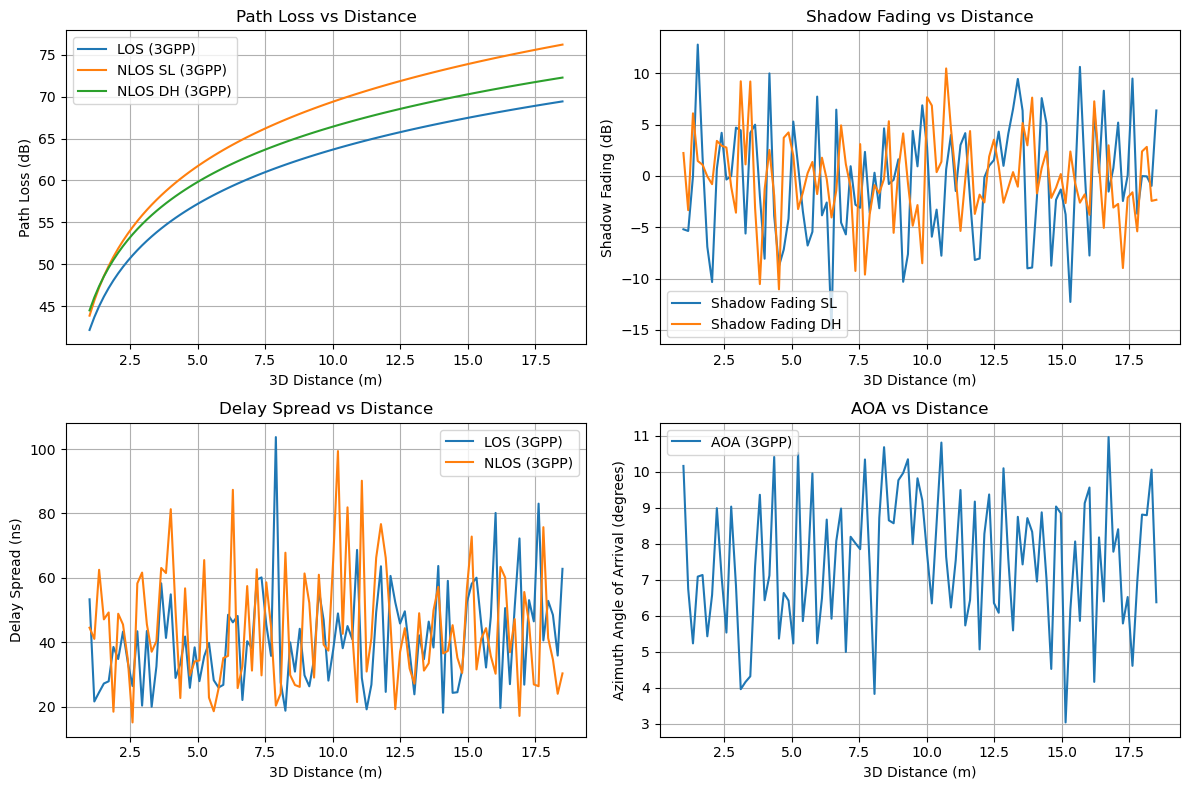

In [14]:
# Parameters based on 3GPP TR 38.901 InF model and your paper
fc = 3.5e9  # Carrier frequency (3.5 GHz)
max_dimension = 18.5  # Maximum room dimension from paper (m)
d_3d = np.linspace(1, max_dimension, 100)  # 3D distance range (m), capped at 18.5 m
d_2d = d_3d  # Approximate 2D distance for simplicity
r_clutter = 0.2  # Low clutter density (20%) for InF-SL, inferred from paper context
h_c = 2.0  # Clutter height (m), assumed based on typical InF setup
h_BS = 8.0  # BS height for InF-SH/DH (m), assumed
h_UT = 1.5  # User Terminal height (m), assumed
V = 18.5 * 13 * 13  # Hall volume (m^3) for 18.5 m × 13 m × 13 m
S = 2 * (18.5 + 13 + 13) * 13  # Surface area (m^2), approximating walls, floor, ceiling

# Path Loss Models (3GPP TR 38.901 Table 7.4.1-1)
def pl_los(d_3d, fc):
    return 31.84 + 21.50 * np.log10(d_3d) + 19.00 * np.log10(fc / 1e9)

def pl_nlos_sl(d_3d, fc):
    return np.maximum(pl_los(d_3d, fc), 33 + 25.5 * np.log10(d_3d) + 20 * np.log10(fc / 1e9))

def pl_nlos_dh(d_3d, fc):
    return np.maximum(pl_los(d_3d, fc), 33.63 + 21.9 * np.log10(d_3d) + 20 * np.log10(fc / 1e9))

# Shadow Fading (Gaussian, std from Table 7.4.1-1)
sigma_sf_sl = 5.7  # dB for InF-SL
sigma_sf_dh = 4.0  # dB for InF-DH
shadow_fading_sl = np.random.normal(0, sigma_sf_sl, len(d_3d))
shadow_fading_dh = np.random.normal(0, sigma_sf_dh, len(d_3d))

# LOS Probability (Table 7.4.2-1)
k_sl = -h_c / np.log(1 - r_clutter)
pr_los_sl = np.exp(-d_2d / k_sl)

# Delay Spread (Table 7.5-6)
mu_lgDS_los = np.log10(26 * (V / S) + 14) - 9.35
sigma_lgDS_los = 0.15
ds_los = 10 ** np.random.normal(mu_lgDS_los, sigma_lgDS_los, len(d_3d))

mu_lgDS_nlos = np.log10(30 * (V / S) + 32) - 9.44
sigma_lgDS_nlos = 0.19
ds_nlos = 10 ** np.random.normal(mu_lgDS_nlos, sigma_lgDS_nlos, len(d_3d))

# AOA (Azimuth Angle of Arrival, wrapped Gaussian approximation)
mu_asa = 8  # Cluster ASA (degrees)
sigma_asa = 2  # Approximate std for simplicity
aoa = np.random.normal(mu_asa, sigma_asa, len(d_3d))
aoa = np.mod(aoa, 360)  # Wrap to [0, 360)

# Paper-specific metrics
pl_measured = 31.84 + 1.611 * np.log10(d_3d) + 0.728  # Path loss from paper
ds_measured = np.linspace(20e-9, 100e-9, len(d_3d))  # Delay spread range from paper

# Plotting
plt.figure(figsize=(12, 8))

# Path Loss
plt.subplot(2, 2, 1)
plt.plot(d_3d, pl_los(d_3d, fc), label='LOS (3GPP)')
plt.plot(d_3d, pl_nlos_sl(d_3d, fc), label='NLOS SL (3GPP)')
plt.plot(d_3d, pl_nlos_dh(d_3d, fc), label='NLOS DH (3GPP)')
#plt.plot(d_3d, pl_measured, '--', label='Measured (Paper)')
plt.xlabel('3D Distance (m)')
plt.ylabel('Path Loss (dB)')
plt.title('Path Loss vs Distance')
plt.legend()
plt.grid()

# Shadow Fading
plt.subplot(2, 2, 2)
plt.plot(d_3d, shadow_fading_sl, label='Shadow Fading SL')
plt.plot(d_3d, shadow_fading_dh, label='Shadow Fading DH')
plt.xlabel('3D Distance (m)')
plt.ylabel('Shadow Fading (dB)')
plt.title('Shadow Fading vs Distance')
plt.legend()
plt.grid()

# Delay Spread
plt.subplot(2, 2, 3)
plt.plot(d_3d, ds_los * 1e9, label='LOS (3GPP)')
plt.plot(d_3d, ds_nlos * 1e9, label='NLOS (3GPP)')
#plt.plot(d_3d, ds_measured * 1e9, '--', label='Measured (Paper)')
plt.xlabel('3D Distance (m)')
plt.ylabel('Delay Spread (ns)')
plt.title('Delay Spread vs Distance')
plt.legend()
plt.grid()

# AOA
plt.subplot(2, 2, 4)
plt.plot(d_3d, aoa, label='AOA (3GPP)')
plt.xlabel('3D Distance (m)')
plt.ylabel('Azimuth Angle of Arrival (degrees)')
plt.title('AOA vs Distance')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

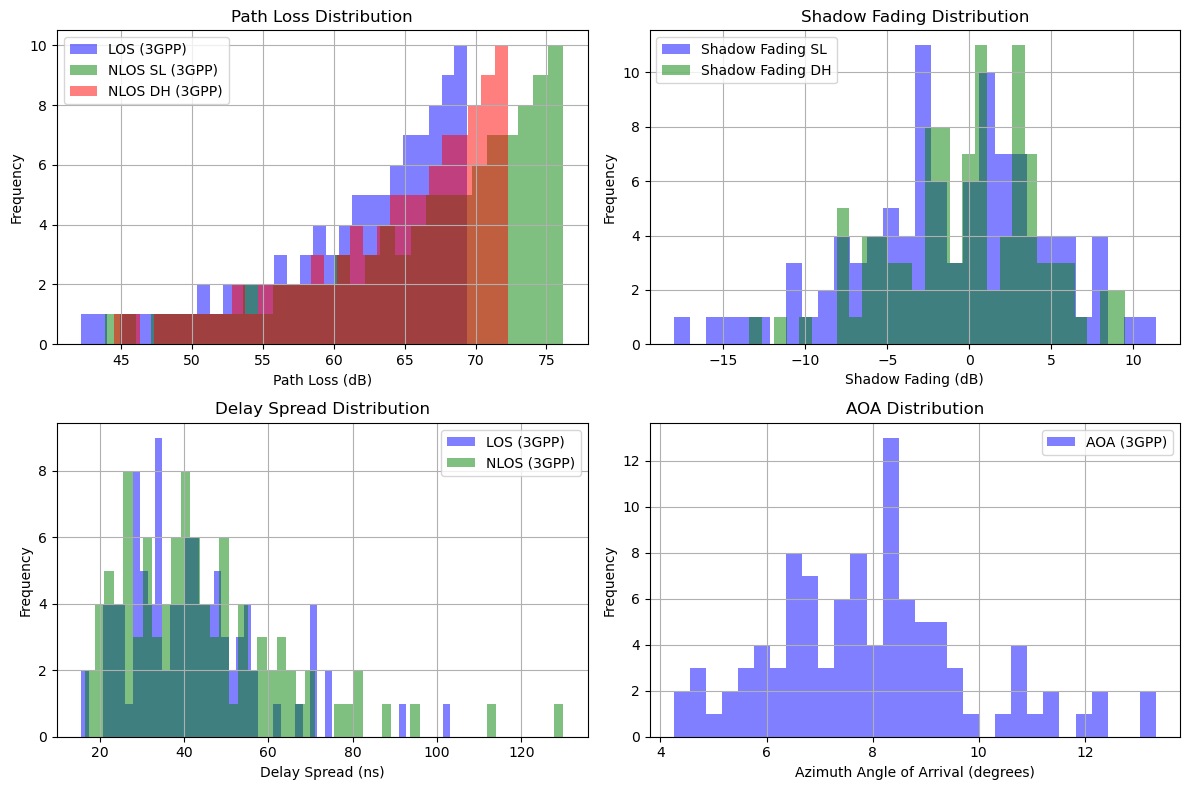

In [13]:
# Plotting Distributions
plt.figure(figsize=(12, 8))

# Path Loss Distribution
plt.subplot(2, 2, 1)
plt.hist(pl_los(d_3d, fc), bins=30, alpha=0.5, label='LOS (3GPP)', color='blue')
plt.hist(pl_nlos_sl(d_3d, fc), bins=30, alpha=0.5, label='NLOS SL (3GPP)', color='green')
plt.hist(pl_nlos_dh(d_3d, fc), bins=30, alpha=0.5, label='NLOS DH (3GPP)', color='red')
#plt.hist(pl_measured, bins=30, alpha=0.5, label='Measured (Paper)', color='orange', linestyle='--')
plt.xlabel('Path Loss (dB)')
plt.ylabel('Frequency')
plt.title('Path Loss Distribution')
plt.legend()
plt.grid()

# Shadow Fading Distribution
plt.subplot(2, 2, 2)
plt.hist(shadow_fading_sl, bins=30, alpha=0.5, label='Shadow Fading SL', color='blue')
plt.hist(shadow_fading_dh, bins=30, alpha=0.5, label='Shadow Fading DH', color='green')
plt.xlabel('Shadow Fading (dB)')
plt.ylabel('Frequency')
plt.title('Shadow Fading Distribution')
plt.legend()
plt.grid()

# Delay Spread Distribution
plt.subplot(2, 2, 3)
plt.hist(ds_los * 1e9, bins=50, alpha=0.5, label='LOS (3GPP)', color='blue')
plt.hist(ds_nlos * 1e9, bins=50, alpha=0.5, label='NLOS (3GPP)', color='green')
#plt.hist(ds_measured * 1e9, bins=30, alpha=0.5, label='Measured (Paper)', color='orange', linestyle='--')
plt.xlabel('Delay Spread (ns)')
plt.ylabel('Frequency')
plt.title('Delay Spread Distribution')
plt.legend()
plt.grid()

# AOA Distribution
plt.subplot(2, 2, 4)
plt.hist(aoa, bins=30, alpha=0.5, label='AOA (3GPP)', color='blue')
plt.xlabel('Azimuth Angle of Arrival (degrees)')
plt.ylabel('Frequency')
plt.title('AOA Distribution')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [15]:
sliding vector coding


SyntaxError: invalid syntax (1090148325.py, line 1)